# Naive Bayes
We will be implementing the Bernoulli version of Naive Bayes.

## Hyperparameter tweaking
Following the assignment guidelines, we will be tweaking three hyperparameters throughout the testing of the project; m (for the size of the vocabulary), n (for the n most common words in the training data), and k (for the k least common words in the training data), the last 2 of which will not be included in the vocabulary.

In [154]:
from sklearn.naive_bayes import BernoulliNB

m = 2500
n = 200
k = 50

## Fetch data
Fetching the reviews, while taking into account the aforementioned m, n and k hyperparameters.

In [155]:
import tensorflow as tf
import numpy as np

# fetching the reviews
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

# make a dictionary out of the words provided according to the above conditions 
word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

# x_train and x_test will consist of strings that represent reviews, but limited to the dictionary provided
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_raw])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_raw])

## Vectorize data

In [156]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)

# transforming the train and test text reviews into binary matrices
x_train_binary = binary_vectorizer.fit_transform(x_train_text)
x_test_binary = binary_vectorizer.transform(x_test_text)

feature_names = binary_vectorizer.get_feature_names_out()

x_train = np.array(x_train_binary.toarray())
x_test = np.array(x_test_binary.toarray())

## Information Gain

In [157]:
import math

def information_gain(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
        pc = list(class_).count(c)/len(class_)
        Hc += - pc * math.log(pc, 2)
    print('Overall Entropy:', Hc)
    feature_values = set(feature)

    hc_feature = 0
    for feat in feature_values:

        #pf --> P(X=x)
        pf = list(feature).count(feat)/len(feature)
        indices = [i for i in range(len(feature)) if feature[i] == feat]
        classes_of_feat = [class_[i] for i in indices]
        for c in classes:
            #pcf --> P(C=c|X=x)
            pcf = classes_of_feat.count(c)/len(classes_of_feat)
            if pcf != 0:
                # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                temp_H = - pf * pcf * math.log(pcf, 2)
                #sum for all values of C (class) and X (values of specific feature)
                hc_feature += temp_H
    ig = Hc - hc_feature
    return ig

## Bernoulli Naive Bayes

In [158]:
class BernoulliNaiveBayes:
    def __init__(self):
        """
        apriori_positive: Initialised to the total number of positive reviews / the total number of reviews from our training data
        apriori_negative: Initialised to the total number of negative reviews / the total number of reviews from our training data
        """
        self.apriori_positive = None
        self.apriori_negative = None
        self.positive_category_feature_exists = None
        self.negative_category_feature_exists = None
    
    def fit(self, x, y):
        alpha = 1   # the parameter used for Laplace smoothing
        
        # apriori_positive/negative: p(C=1)/p(C=0) respectively for the training data
        self.apriori_positive = len(np.where(y == 1)[0]) / len(y)
        self.apriori_negative = len(np.where(y == 0)[0]) / len(y)

        """
        positive_category_feature_exists/negative_category_feature_exists are two arrays of size equal to the total amount
        of features (words in the vocabulary). Each index represents the (smoothed) probability the category will be
        positive or negative respectively, given that the feature in that specific index is present in the training data.
        In other words, for the m features present, the item on the i-th index of positive_category_feature_exists represents
        the probability of p(Xi = xi | C = 1) for the i-th feature, and likewise p(Xi = xi | C = 0) for the negative category. 
        """        
        self.positive_category_feature_exists = (np.sum(x[y == 1], axis=0) + alpha) / (len(np.where(y == 1)[0]) + 2 * alpha)
        self.negative_category_feature_exists = (np.sum(x[y == 0], axis=0) + alpha) / (len(np.where(y == 0)[0]) + 2 * alpha)
        
        return self
    
    def predict(self, x):

        num_test_data = x.shape[0]

        # making 2 num_test_data sized arrays consisting of the apriori positive/negative probabilities (to optimise the multiplication that follows)
        positive_probs = np.full(num_test_data, self.apriori_positive)
        negative_probs = np.full(num_test_data, self.apriori_negative)

        """
        for each test sample, we multiply the apriori probabilities with feature-specific probabilities,
        considering feature presence (positive/negative_category_feature_exists) or absence (complement
        probabilities). Probabilities are filtered through exponentiation: x for feature presence, 1-x
        for absence (since x==1 means the feature is present, and x==0 means the feature is absent).
        """
        positive_probs *= np.prod(self.positive_category_feature_exists ** x * (1 - self.positive_category_feature_exists) ** (1 - x), axis=1)
        negative_probs *= np.prod(self.negative_category_feature_exists ** x * (1 - self.negative_category_feature_exists) ** (1 - x), axis=1)

        # for each test sample, choose the class with the higher probability for the final prediction
        predictions = np.where(positive_probs > negative_probs, 1, 0)

        return predictions

## Initial analysis
Checking how well our naive bayes classifier performed against the test data, with the help of sklearn's classification report and confusion matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


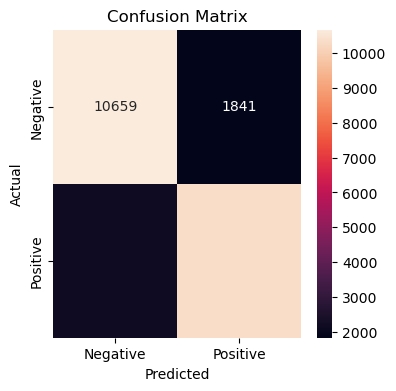

In [160]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

bernoulli_naive_bayes = BernoulliNaiveBayes()
bernoulli_naive_bayes.fit(x_train, y_train)
predictions = bernoulli_naive_bayes.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, predictions))

# on top of the classification report, showcasing the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True)
heatmap.set_xticklabels(["Negative", "Positive"])
heatmap.set_yticklabels(["Negative", "Positive"])
heatmap.set(title="Confusion Matrix Heatmap", xlabel="Predicted", ylabel="Actual")
plt.show()